# Import modules

In [1]:
#import general modules
import numpy as np
import io, sys, time, math, os.path, unittest, sys,random,os

#import data analysis tools
import matplotlib.pyplot as plt
import pandas as pd

#import statistics tool for multivariate linear regression
import statsmodels.api as sm

#import machine learning tools for constructing a decision tree
from sklearn.externals.six import StringIO 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import pydot
from IPython.display import Image 

# Load files

In [3]:
#Todo: use sys commands to dynamically find in github folder
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/Dept_Interior_Data/'

file_name='NRRS_reservations_byVisitorOriginZip_AllYears.csv'
zip_origin_df=pd.read_csv(file_location+file_name)

file_name='NRRS_reservations_byFacilityName_AllYears.csv'
by_campground_df=pd.read_csv(file_location+file_name)

file_name='PPL_reservationdata.csv' #2.2gb --> very large
reservation_df=by_campground_df=pd.read_csv(file_location+file_name)


In [4]:
#load models (distance to park)
github_folder='/Users/mrubashkin/greenspace/'
file_location=github_folder+'raw_data/'
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
#distance_to_park_df[['D2NF_km','ZIP_CODE']]

In [5]:
#Census Data
file_location=github_folder+'raw_data/'

file_name='aggregate_income.csv'
income_df=pd.read_csv(file_location+file_name)

file_name='2010CensusPopulationData.csv'
racial_info_df=pd.read_csv(file_location+file_name)

#distance from zip code to the park
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
distance_to_park_df[['D2NF_km','ZIP_CODE']]

#health/disabilty
file_name='disability.csv'
disability_df=pd.read_csv(file_location+file_name)
'''
TODO: Rename these columns, the one 'total is a BAD idea
'''

file_name='education.csv'
education_df=pd.read_csv(file_location+file_name)
education_df.rename(columns={'zip code tabulation area': 'zip_code_tabulation_area'},inplace=True)
education_df.rename(columns={'B06009_001E': 'Total_reported_education_per_zip'},inplace=True)
education_df.rename(columns={'B06009_002E': 'Less_than_high_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_003E': 'High_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_004E': 'Some_college_or_associates_degree'},inplace=True)
education_df.rename(columns={'B06009_005E': 'Bachelor_degree'},inplace=True)
education_df.rename(columns={'B06009_006E': 'Graduate_or_professional_degree'},inplace=True)
education_df=education_df[['zip_code_tabulation_area','Less_than_high_school_graduate','High_school_graduate'
                ,'Some_college_or_associates_degree','Bachelor_degree','Graduate_or_professional_degree'
                ,'Total_reported_education_per_zip']]
#education_df

In [6]:
#drop the duplicate columns and use to merge
temp=reservation_df.drop_duplicates(subset = ' CustZip')
temp=temp[[' CustState',' CustCountry',' CustZip']]
temp[' CustZip']=pd.to_numeric(temp[' CustZip'], errors='coerce')

# Join dataframes

In [7]:
#join the dataframes
aggregate_df= pd.merge(zip_origin_df, racial_info_df, left_on = 'visitor_zip', right_on = 'Zip')
aggregate_df= pd.merge(aggregate_df,income_df,left_on='visitor_zip',right_on='zip code tabulation area')
#move the line below to higher up
aggregate_df.rename(columns={'Annual Aggregate Family Income': 'Annual_Aggregate_Family_Income'},inplace=True)
aggregate_df= pd.merge(aggregate_df,temp,left_on = 'visitor_zip', right_on = ' CustZip')
aggregate_df= pd.merge(aggregate_df,education_df,left_on='visitor_zip',right_on='zip_code_tabulation_area')
aggregate_df= pd.merge(aggregate_df,distance_to_park_df,left_on='visitor_zip',right_on='ZIP_CODE')
aggregate_df= pd.merge(aggregate_df,disability_df, left_on='visitor_zip',right_on='zipcode')
#aggregate_df

In [8]:
print aggregate_df.columns[0:50]
print aggregate_df.columns[50:-1]

Index([u'visitor_zip', u'visitorzip_lat', u'visitorzip_lon', u'qpartysize25',
       u'qpartysize50', u'qpartysize75', u'qleadt25', u'qleadt50', u'qleadt75',
       u'qdur25', u'qdur50', u'qdur75', u'qdist25', u'qdist50', u'qdist75',
       u'res_count', u'sum_dur', u'sum_persnight', u'Zip', u'Population',
       u'PopulationMale', u'PopulationFemale', u'MedianAge', u'MedianAgeMale',
       u'MedianAgeFemale', u'PopulationRaceWhite', u'PopulationRaceBlack',
       u'PopulationAmerindian', u'PopulationRaceAsian',
       u'PopulationRacePacific', u'PopulationRaceOther',
       u'PopulationRaceMulti', u'PopulationRaceLatino', u'Households',
       u'HusbandWifeHouseholds', u'SingleFatherHousehold',
       u'SingleMotherHousehold', u'NonFamilyHouseholds', u'HouseHolder15to24',
       u'HouseHolder25to34', u'HouseHolder35to44', u'HouseHolder45to54',
       u'HouseHolder55to59', u'HouseHolder60to64', u'HouseHolder65to74',
       u'HouseHolder75to84', u'HouseHolder85over', u'HouseholdsWith60P

In [9]:
#rename columns without spaces
aggregate_df.rename(columns={' CustZip': 'CustZip'},inplace=True)
aggregate_df.rename(columns={' CustState': 'CustState'},inplace=True)
aggregate_df.rename(columns={' CustCountry': 'Custcountry'},inplace=True)
aggregate_df.iloc[0]['Custcountry']

'USA'

# Create new columns

In [10]:
#get the utilization_factors into the dataframe
aggregate_df['util_unique'] = pd.Series(
    (aggregate_df.sum_dur / aggregate_df.Population))
aggregate_df['util_days']= pd.Series(
    (aggregate_df.sum_persnight  / aggregate_df.Population))

In [11]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['sum_dur']\
    /float(aggregate_df.iloc[[0]]['Population'])),\
     float(aggregate_df.iloc[[0]]['util_unique']))

This 0.000754 should equal that 0.000754


In [12]:
#get the male/female breakdowns per visit per zip code
#using unique visits for the rest of these breakdowns!! (i.e. sum_dur)
aggregate_df['visits_female'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))
aggregate_df['visits_male'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))

In [13]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationFemale']\
    /float(aggregate_df.iloc[[0]]['Population']))\
    *float(aggregate_df.iloc[[0]]['sum_dur']),\
     float(aggregate_df.iloc[[0]]['visits_female']))

This 7.156058 should equal that 7.156058


In [14]:
#get the race breakdown per visit per zip code
aggregate_df['visits_RaceWhite'] = pd.Series(
    (aggregate_df.PopulationRaceWhite * aggregate_df.sum_dur))
aggregate_df['visits_RaceBlack'] = pd.Series(
    (aggregate_df.PopulationRaceBlack * aggregate_df.sum_dur))
aggregate_df['visits_Amerindian'] = pd.Series(
    (aggregate_df.PopulationAmerindian * aggregate_df.sum_dur))
aggregate_df['visits_RacePacific'] = pd.Series(
    (aggregate_df.PopulationRacePacific * aggregate_df.sum_dur))
aggregate_df['visits_RaceLatino'] = pd.Series(
    (aggregate_df.PopulationRaceLatino * aggregate_df.sum_dur))
aggregate_df['visits_RaceMulti'] = pd.Series(
    (aggregate_df.PopulationRaceMulti * aggregate_df.sum_dur))
aggregate_df['visits_RaceOther'] = pd.Series(
    (aggregate_df.PopulationRaceOther * aggregate_df.sum_dur))

In [15]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationRaceWhite']\
    *float(aggregate_df.iloc[[0]]['sum_dur'])),\
     float(aggregate_df.iloc[[0]]['visits_RaceWhite']))

This 0.060312 should equal that 0.060312


In [16]:
#scale the annual family aggregate income (which is per zip code)
#to individual families
aggregate_df['per_family_annual_income'] = pd.Series(
    ( (aggregate_df.Annual_Aggregate_Family_Income / aggregate_df.Households)))

In [17]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['Annual_Aggregate_Family_Income']\
    /float(aggregate_df.iloc[[0]]['Households'])),\
     float(aggregate_df.iloc[[0]]['per_family_annual_income']))


This 16366.160920 should equal that 16366.160920


In [18]:
#get percent of people who are high school educated
aggregate_df['non_hs_educated'] = pd.Series(
    (1-aggregate_df.Less_than_high_school_graduate / aggregate_df.Total_reported_education_per_zip))
print aggregate_df['non_hs_educated'][0:10] 

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: non_hs_educated, dtype: float64


In [19]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[-1]]['Less_than_high_school_graduate']\
    /float(aggregate_df.iloc[[-1]]['Total_reported_education_per_zip'])),\
     float(aggregate_df.iloc[[-1]]['non_hs_educated']))

This 0.109489 should equal that 0.890511


In [20]:
#get percent of people who are high school educated
aggregate_df['disabled_percent'] = pd.Series(
    (aggregate_df.disabled / aggregate_df.total))

In [21]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[-1]]['disabled']\
    /float(aggregate_df.iloc[[-1]]['total'])),\
     float(aggregate_df.iloc[[-1]]['disabled_percent']))

This 0.257353 should equal that 0.257353


# Trim data

In [22]:
#create the data to send to Cartos DB and use for the graphing
regression_df=aggregate_df[[
        'CustZip',
        'CustState',
        'Custcountry',
        'visitorzip_lat',
        'visitorzip_lon',
        'per_family_annual_income',
        'non_hs_educated',
        'PopulationRaceWhite',
        'D2NF_km',
        'util_days',
        'disabled_percent',
        'MedianAge',
        ]]
#remove inf and NaN
regression_df=regression_df.replace([np.inf, -np.inf], np.nan).dropna()
#rename the distance column
regression_df.rename(columns={'D2NF_km': 'Dist_to_park'},inplace=True)
#save the max values    
income_max=regression_df['per_family_annual_income'].max()
dist_to_park_max=regression_df['Dist_to_park'].max()
#print random entry
regression_df.iloc[1000]

CustZip                          4460
CustState                          ME
Custcountry                       USA
visitorzip_lat                45.6494
visitorzip_lon                -68.579
per_family_annual_income      38083.6
non_hs_educated              0.877016
PopulationRaceWhite          0.987315
Dist_to_park                  140.192
util_days                   0.0190275
disabled_percent             0.212673
MedianAge                        48.2
Name: 1092, dtype: object

In [23]:
#for Mythin
regression_df['log_util_days'] = pd.Series(
    (np.log(regression_df.util_days)))

## Save the trimmed datframe to database

In [25]:
#save the dataframe to a csv
file_location=github_folder + 'processed_data/'
file_name='test9_with_log_util_days.csv'
regression_df.to_csv(file_location+file_name, sep=',')

## Scale the columns to 0 to 1 for machine learning

In [26]:
#scale columns to 0-->1
regression_df[['per_family_annual_income']]=\
regression_df[['per_family_annual_income']].divide(\
    regression_df['per_family_annual_income'].max())
regression_df[['Dist_to_park']]=\
regression_df[['Dist_to_park']].divide(\
    regression_df['Dist_to_park'].max())
regression_df[['MedianAge']]=\
regression_df[['MedianAge']].divide(\
    regression_df['MedianAge'].max())
#remove inf and NaN
regression_df=regression_df.replace([np.inf, -np.inf], np.nan).dropna()

# Linear Regression

In [27]:
#remove potential ouliers
min_visitation_value=.01
regression_df_editted = regression_df[regression_df.util_days > min_visitation_value]

y=regression_df_editted['util_days'].tolist()

x=[regression_df_editted['per_family_annual_income'].tolist(),
   regression_df_editted['non_hs_educated'].tolist(),
   regression_df_editted['PopulationRaceWhite'].tolist(),
   regression_df_editted['Dist_to_park'].tolist(),
   regression_df_editted['disabled_percent'].tolist(),
   regression_df_editted['MedianAge'].tolist()
   ]

#calculate the y-intercept guess
y_intercept_guess=regression_df_editted['util_days'].median()
y_intercept_guess=0

def reg_m(y, x, y_intercept_guess):
    y_intercepts = np.empty(len(x[0]))
    y_intercepts.fill(y_intercept_guess)
    X = sm.add_constant(np.column_stack((x[0], y_intercepts)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

reg_m(y,x,y_intercept_guess)
print reg_m(y, x,y_intercept_guess).summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     1598.
Date:                Sun, 24 Apr 2016   Prob (F-statistic):               0.00
Time:                        02:50:10   Log-Likelihood:                -57065.
No. Observations:               29698   AIC:                         1.141e+05
Df Residuals:                   29692   BIC:                         1.142e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.2064      0.147     -1.402      0.1

# Decision Tree (data prep, ML and analysis)

In [80]:
def training_sample_index(training_size):
    #Create random sampling array
    #cannot be larger than the availble data
    r_df_length=len(regression_df_editted['util_days'])
    total_samples=int(training_size*r_df_length)
    training_sample=random.sample(range(0, r_df_length), total_samples)
    #print training_sample[0:10]
    return training_sample

def build_training_set(training_sample,df_as_list):
    #open df as list and store temporarily
    #df_list=regression_df_editted['util_days'].tolist()\
    df_output=[]
    for i in range(0,len(training_sample)):
        df_output.append(df_as_list[training_sample[i]])
        '''
        TODO: Create unittest confirming here that we are returning the
        correct mixed index values
        '''
    return df_output

In [81]:
def bucket_and_prob_creator(buckets):
    # Convert util_days (average person visits to park over 7 years) to ranking 1-5(low-high)
    '''
    TODO: make this a function that does not rely on global variables
    NOT CURRENTLY WORKING
    '''
    a = regression_df_editted['util_days'].tolist()
    p=[]
    for i in range(0,len(buckets)):
        p.append(np.percentile(a, buckets[i]))
    return p

def assign_class_to_value(input_value,buckets,p,output_classes):
    for i in range(1,len(buckets)):
        if i==len(buckets):
            return output_classes[i]
        if input_value<=p[i]:
            return output_classes[i-1]
        else:
            pass

In [82]:
'''
TODO: Create a configuration file where the 'training size' variable is kept
'''
training_size=0.8
#create training sample index and build training set
training_sample=training_sample_index(training_size)
r_df_lists={}
#create a list index
list_index=['util_days','per_family_annual_income','non_hs_educated',
           'PopulationRaceWhite','Dist_to_park','disabled_percent','MedianAge']
#took out CustState - No non numeric variables allowed in scikit learn

#then iterate through the other data
for i in range(0,len(list_index)):
    r_df_lists[list_index[i]]=\
        build_training_set(training_sample,regression_df_editted[list_index[i]].tolist())
#print r_df_lists['per_family_annual_income'][0:100]

In [83]:
#assign classes for decision tree to the util_days value range
buckets=[0,20,40,60,80,100]
output_classes=[0,1,2,3,4]
p=bucket_and_prob_creator(buckets)
 
for i in range(0,len(r_df_lists['util_days'])):
    r_df_lists['util_days'][i]= \
        assign_class_to_value(r_df_lists['util_days'][i],buckets,p,output_classes)
'''
TODO Write a test to make sure these are all integers and members of the output_classes array
#print r_df_lists['util_days'][0:30]
'''

#convert all lists in r_df_lists dictionary to numpy array
keys=r_df_lists.keys()
for key in keys:
    r_df_lists[key]=np.array(r_df_lists[key])

# Decision Tree Logic

In [84]:
'''
TODO: Set configurations in an importable file in the future
'''
max_depth=4

#The target classes
y=np.array(r_df_lists['util_days'])

#convert the x into the appropriate format
x=[]
for i in range(0,len(r_df_lists[keys[0]])): #start at 1 to skip util_days
    temp=[]
    for key in keys:
        if key != 'util_days':
            temp.append(r_df_lists[key][i])
    x.append(temp)
x=np.array(x)    

#construct the tree
print 'About to construct the decision tree. This may take awhile...'
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(x, y)

About to construct the decision tree. This may take awhile...


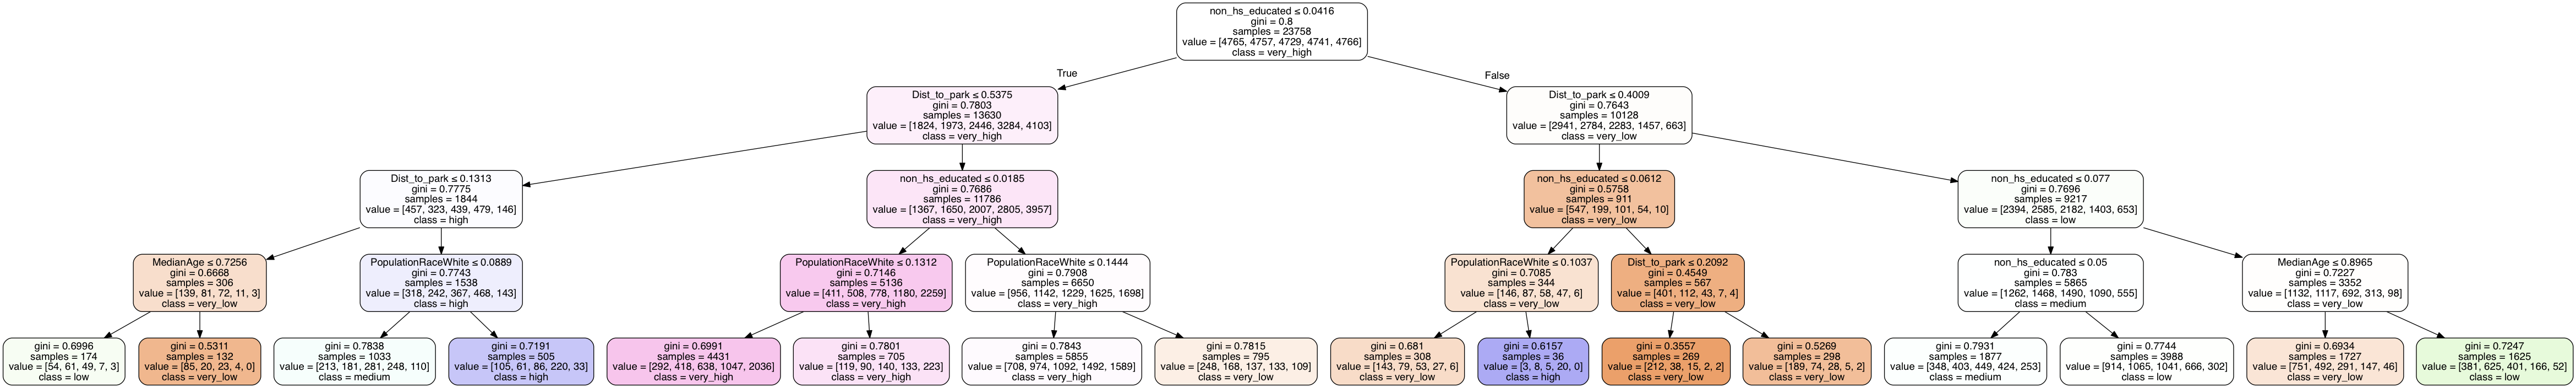

In [85]:
from sklearn.externals.six import StringIO
file_title="tree_demo_v0_0_1"
with open(file_title+'.dot', 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

os.unlink(file_title+'.dot')

dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf(file_title+'.pdf') 
 
dot_data = StringIO() 

#create list of names for features and classes
feature_names=list_index[1:]
target_names=['very_low','low','medium','high','very_high'] #quintiles
tree.export_graphviz(clf, out_file=dot_data,  
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf(file_title+'_wColor'+'.pdf') 
Image(graph.create_png())  

In [ ]:
print(__doc__)

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

# Plot correlations

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,15))
plt.semilogy(regression_df['PopulationRaceWhite'],regression_df['util_days'],'ro',\
             regression_df['per_family_annual_income'],regression_df['util_days'],'bo',\
             regression_df['Dist_to_park'],regression_df['util_days'],'go',\
             regression_df['non_hs_educated'],regression_df['util_days'],'ko',\
             regression_df['disabled_percent'],regression_df['util_days'],'co',markersize = 2
             )

plt.xlabel('Percent of zip code white',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)
plt.legend(loc='upper right',prop={'size':12})


In [ ]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['per_family_annual_income'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Family Income',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['Dist_to_park'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Distance_to_park',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by distance to park', size=13)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['non_hs_educated'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Distance_to_park',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Education Status (1=not high school educated) \n per zipcode', size=13)